In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join(os.environ['HOME'],'a2e-mmc','mmctools')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum, plot_timeheight
import assessment.studies.budget_components_coupling.helpers as helper
from mmctools.helper_functions import calc_wind, power_spectral_density

In [5]:
import mmctools.plotting as mplt
mplt.standard_fieldlabels = mplt.fieldlabels_superscript_units
mplt.standard_spectrumlabels = mplt.spectrumlabels_superscript_units

In [6]:
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT budget components coupling study: Plot microscale comparison
written by [Dries Allaerts](mailto:dries.allaerts@nrel.gov)

updated by [Eliot Quon](mailto:eliot.quon@nrel.gov), 2020-03-02

Produce figures for the paper, "Coupling mesoscale momentum and temperature budget components to a microscale LES solver for wind energy applications", under submission to Boundary-Layer Meteorology. This notebook depends on:
- SOWFA simulations
 - `run.tency.w0_L0`
 - `run.tency.w60_L0`
 - `run.tency.w120_L0`
 - `run.tency.w180_L0`
 - `run.tency.w0_L6000`
 - `run.tency.w60_L6000`
 - `run.tency.w120_L6000`
 - `run.tency.w180_L6000`
 - `run.tency.w0_L24000`
 - `run.tency.w60_L24000`
 - `run.tency.w120_L24000`
 - `run.tency.w180_L24000`
- reference data:
 - WRF data (version 3.7.1), extracted from the actual SOWFA input files
 - TTU tower data, generated in `process_TTU_tower.ipynb`

Main directories on Eagle

In [7]:
datadir = '/projects/mmc/dallaert/budget_component_coupling/'
referencedir = '/projects/mmc/dallaert/referenceData/'

Name of SOWFA simulation folder

In [8]:
prefix = 'run.tency.'
simulation_data = {
    'L3_T0':    os.path.join(datadir,prefix+'w0_L0'),
    'L3_T60':   os.path.join(datadir,prefix+'w60_L0'),
    'L3_T120':  os.path.join(datadir,prefix+'w120_L0'),
    'L3_T180':  os.path.join(datadir,prefix+'w180_L0'),
    'L9_T0':    os.path.join(datadir,prefix+'w0_L6000'),
    'L9_T60':   os.path.join(datadir,prefix+'w60_L6000'),
    'L9_T120':  os.path.join(datadir,prefix+'w120_L6000'),
    'L9_T180':  os.path.join(datadir,prefix+'w180_L6000'),
    'L27_T0':   os.path.join(datadir,prefix+'w0_L24000'),
    'L27_T60':  os.path.join(datadir,prefix+'w60_L24000'),
    'L27_T120': os.path.join(datadir,prefix+'w120_L24000'),
    'L27_T180': os.path.join(datadir,prefix+'w180_L24000'),
}

Reference data

In [9]:
# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
tower_data_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
tower_data       = 'TTU_tilt_corrected_20131108-09.csv'

# WRF data is extracted from the SOWFA input files
wrf_data = 'drivingData_Rerun/w0_L0'

Heights and times at which spectra are computed

In [10]:
zhub = [80., ]
selected_times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00']

Output folder to store figures

In [11]:
figuredir = 'Figures'

if not os.path.isdir(figuredir):
    os.makedirs(figuredir)

## 1. Load microscale data

In [12]:
%%time
micro_pavg_10min = {}
for name in simulation_data.keys():
    print('Loading simulation '+name)
    
    fpath = os.path.join(simulation_data[name],'postProcessing/planarAverages')
    df = helper.reader_planar_average(fpath)
    
    # Resample data to 10-min averages
    df_10min = df.unstack().resample('10min').mean().stack()
    # Calculate some quantities of interest
    helper.calc_QOIs(df_10min)
    # Store result in dictionary
    micro_pavg_10min[name] = df_10min

# CPU times: user 7min 2s, sys: 36.7 s, total: 7min 39s
# Wall time: 21min 17s

Loading simulation L3_T0
Simulation (re)start times: [43200.0, 72000.0]
  read U
  read UU
  read T
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
Loading simulation L3_T60
Simulation (re)start times: [43200.0]
  read U
  read UU
  read T
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
Loading simulation L3_T120
Simulation (re)start times: [43200.0]
  read U
  read UU
  read T
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
Loading simulation L3_T180
Simulation (re)start times: [43200.0]
  read U
  read UU
  read T
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
Loading simulation L9_T0
Simulation (re)start times: [43200.0]
  read U
  read UU
  read T
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
Loading simulation L9_T60
Simulation (re)start times: [43200.0]
  read U
  read UU
  read T
Creating dataframe for [

In [13]:
%%time
micro_prob_fspec = {}
for name in simulation_data.keys():
    print('Loading simulation '+name)
    
    fpath = os.path.join(simulation_data[name],'postProcessing/probe1')
    df_prob = helper.reader_probe(fpath)
    
    # Compute wind speed and wind direction
    df_prob['wspd'], df_prob['wdir'] = calc_wind(df_prob)
    
    # Calculate frequency spectrum
    df_prob_hgts = helper.interpolate_to_heights(df_prob,zhub)
    df_prob_hgts = helper.reindex_if_needed(df_prob_hgts)
    micro_prob_fspec[name] = helper.calc_spectra(df_prob_hgts,selected_times,zhub,interval='1h',window_size='10min')

# CPU times: user 23min 39s, sys: 2min 28s, total: 26min 7s
# Wall time: 26min 11s

Loading simulation L3_T0
Simulation (re)start times: [43200.0, 72000.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
Loading simulation L3_T60
Simulation (re)start times: [43200.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
Loading simulation L3_T120
Simulation (re)start times: [43200.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
Loading simulation L3_T180
Simulation (re)start times: [43200.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
Loading simulation L9_T0
Simulation (re)start times: [43200.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
Loading simulation L9_T60
Simulation (re)start times: [43200.0]
  read U
  read T
Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
L

## 2. Load reference data

In [14]:
%%time
tower_10min, _ = helper.load_tower_reference_data(os.path.join(referencedir,tower_data_10min))

# CPU times: user 48.2 ms, sys: 3.9 ms, total: 52.1 ms
# Wall time: 98.4 ms

CPU times: user 33.4 ms, sys: 2.18 ms, total: 35.5 ms
Wall time: 70.9 ms


In [15]:
%%time
tower_fspec = helper.load_tower_reference_spectra(os.path.join(referencedir,tower_data),
                                                    selected_times,zhub,
                                                    interval='1h',window_size='10min')

# CPU times: user 5.62 s, sys: 53 ms, total: 5.67 s
# Wall time: 13.1 s

CPU times: user 4.79 s, sys: 209 ms, total: 4.99 s
Wall time: 5.13 s


In [16]:
%%time
data = helper.load_wrf_reference_data(os.path.join(datadir,wrf_data))
wrf_pavg_10min = data[0]

# CPU times: user 6.42 s, sys: 30.5 ms, total: 6.45 s
# Wall time: 14.4 s

CPU times: user 2.51 s, sys: 6.28 ms, total: 2.52 s
Wall time: 2.58 s


## 3. Plot results

### Figure 13

Note: considering adding contour lines or moving to discrete color levels to highlight differences

CPU times: user 6.62 s, sys: 30.3 ms, total: 6.65 s
Wall time: 6.68 s


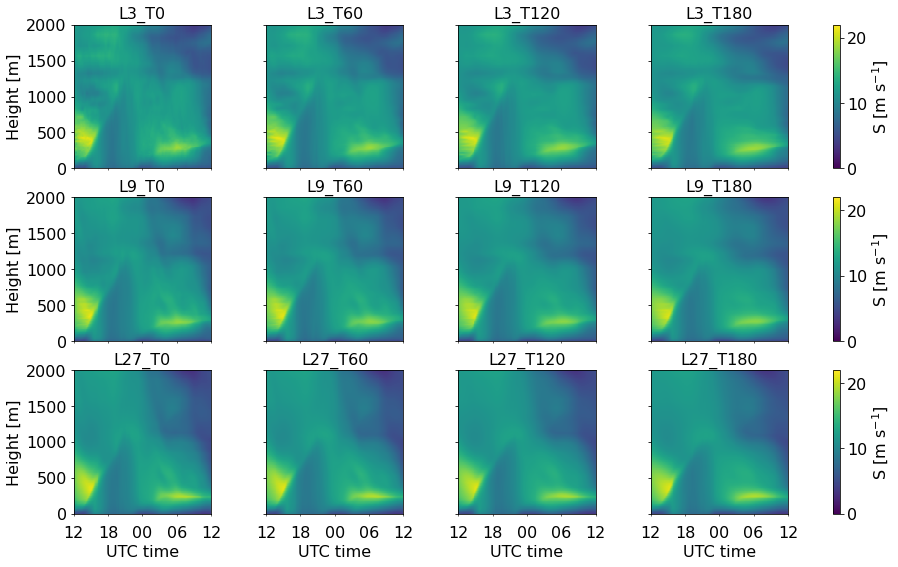

In [29]:
%%time
fig,ax, cbar = plot_timeheight(
    datasets = micro_pavg_10min,
    fields='wspd',
    fieldlimits=(0,22),
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # Order plots in a grid of 2 by 2
    ncols=4,
    # Do not show colorbars
    showcolorbars=False,
    # Set subfigure size
    subfigsize=(4,3),
    # Set raterized to True to reduce size of eps and pdf figures
    rasterized=True
)

fig.subplots_adjust(wspace=0.4)

# Adjust xaxis tick locations
ax[0,0].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=6))
ax[0,0].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax[0,0].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d'))

# Hide dates
ax[0,0].set_xticks([])

# Add colorbars to last column
cbar = plt.colorbar(ax[0,0].collections[-1],ax=ax[0,:])
cbar.set_label('S [m s$^{-1}$]')
cbar = plt.colorbar(ax[1,0].collections[-1],ax=ax[1,:])
cbar.set_label('S [m s$^{-1}$]')
cbar = plt.colorbar(ax[2,0].collections[-1],ax=ax[2,:])
cbar.set_label('S [m s$^{-1}$]')

#Move xs tick down slightly to avoid overlap with y ticks
for axi in np.asarray(ax[-1,:]).ravel():
    axi.tick_params(axis='x', which='minor', pad=10)
    axi.tick_params(axis='x', which='major', pad=10)

#Save figure
figname = 'all_wspd'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')

# CPU times: user 7.95 s, sys: 7.6 s, total: 15.5 s
# Wall time: 16.8 s

### Figure 14

In [18]:
# Gather statistics for selected fields
#selected_fields = ['wspd','wdir','thetav','alpha','psi','TKE','TI']
selected_fields = ['wspd','wdir','thetav','thetav_gradient','alpha','psi','TKE','TI']

# Gather statistics for several time periods starting at
# selected_times covering a certain time interval
interval = '1h'

# Simulations to compute metrics for
selected_sims = ['wrf',] + list(simulation_data.keys())

# Metrics that will be considered
metrics = ['MAE','ME','STD']

# Dimensions of reference rotor span
hubheight = 120.       # Hub height of interest
diameter  = 160.   # Rotor diameter of interest

#### Compute rotor-averaged quantities

Average quantities of interest vertically over a region representative of a reference rotor span with given `diameter` and `hubheight`. The averaging is strictly over the vertical direction and the horizontal extent does not vary with height, i.e., the effective area of different horizontal segments corresponding to different vertical locations across the swept rotor area are not taken into account.

In [19]:
tower_10min['thetav']

datetime             height
2013-11-08 00:00:00  0.9       293.156527
                     2.4       293.279976
                     4.0       293.567532
                     10.1      293.761494
                     16.8      293.906843
                                  ...    
2013-11-09 23:50:00  47.3      301.771535
                     74.7      302.027572
                     116.5     301.975277
                     158.2     302.128355
                     200.0     302.215957
Name: thetav, Length: 2880, dtype: float64

In [20]:
# calculate temperature gradient (EWQ)
tower_10min['thetav_gradient'] = helper.calc_grad(tower_10min['thetav'])
wrf_pavg_10min['thetav_gradient'] = helper.calc_grad(wrf_pavg_10min['thetav'])
for sim in simulation_data.keys():
    micro_pavg_10min[sim]['thetav_gradient'] = helper.calc_grad(micro_pavg_10min[sim]['thetav'])

In [21]:
df_ravg = {}
df_ravg['tower'] = helper.calc_rotor_average(tower_10min,hubheight,diameter)
df_ravg['wrf']   = helper.calc_rotor_average(wrf_pavg_10min,hubheight,diameter)
for sim in simulation_data.keys():
    df_ravg[sim] = helper.calc_rotor_average(micro_pavg_10min[sim],hubheight,diameter)

#### Calculate mean error and standard deviation from average over rotor region

Step 1: Create an empty Dataframe with appropriate number of indices and columns

In [22]:
# Create index
midx = pd.MultiIndex.from_product([pd.to_datetime(selected_times), # Selected times
                                   metrics,                        # Metrics
                                   selected_sims],                 # List of simulations including wrf
                                  names=['datetime','metric','sim'])

# Create field of NaNs to fill dataframe
nanfield = np.nan*np.ones((midx.size,len(selected_fields)))

# Create dataframe
metrics = pd.DataFrame(nanfield,columns=selected_fields,index=midx)

In [23]:
# Loop over different time periods
for time in selected_times:
    # Start and end of the period for which error metrics are calculated
    tstart = pd.to_datetime(time)
    tend   = tstart + pd.to_timedelta(interval)
    
    # Get observed rotor-averaged quantities for current period
    obs = df_ravg['tower']
    obs = obs.loc[(obs.index.get_level_values(0)>=tstart) &\
                   (obs.index.get_level_values(0)<=tend)].copy()
    
    # Loop over different datasets
    for dfname in selected_sims:
            
        # Get simulated rotor-averaged quantities for current period
        df  = df_ravg[dfname]
        df  = df.loc[(df.index.get_level_values(0)>=tstart) &\
                                   (df.index.get_level_values(0)<=tend)].copy()
        
        # Loop over different quantities of interest
        for field in selected_fields:
            try:
                # Compute metrics and store in dataframe
                metrics.loc[(time,'MAE',dfname),field] = np.nanmean(np.abs(df[field].values-obs[field].values))
                metrics.loc[(time,'ME',dfname),field]  = (df[field].values-obs[field].values).mean()
                metrics.loc[(time,'STD',dfname),field] = (df[field].values-obs[field].values).std()
            except KeyError:
                pass

#### Plot performance metrics

In [24]:
# 15-color palettes for color blindness (http://mkweb.bcgsc.ca/colorblind/)
D1_swatch_A = ['#A50F15','#DE2D26','#FB6A4A','#FCAE91','#FEE5D9']
D1_swatch_B = ['#3C690F','#5F820A','#64AA2D','#82D78C','#BEFAD7']
D1_swatch_C = ['#78500F','#967314','#CD913C','#E1BE91',]
D2_swatch_D = ['#08519C','#3182BD','#6BAED6','#BDD7E7','#EFF3FF']
D3_swatch_H = ['#193C37','#1E645F','#46AA96','#28EBC8','#E1FFF5']
D3_swatch_I = ['#501937','#A03764','#D782A0','#EBAFBE','#FAEBF0']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


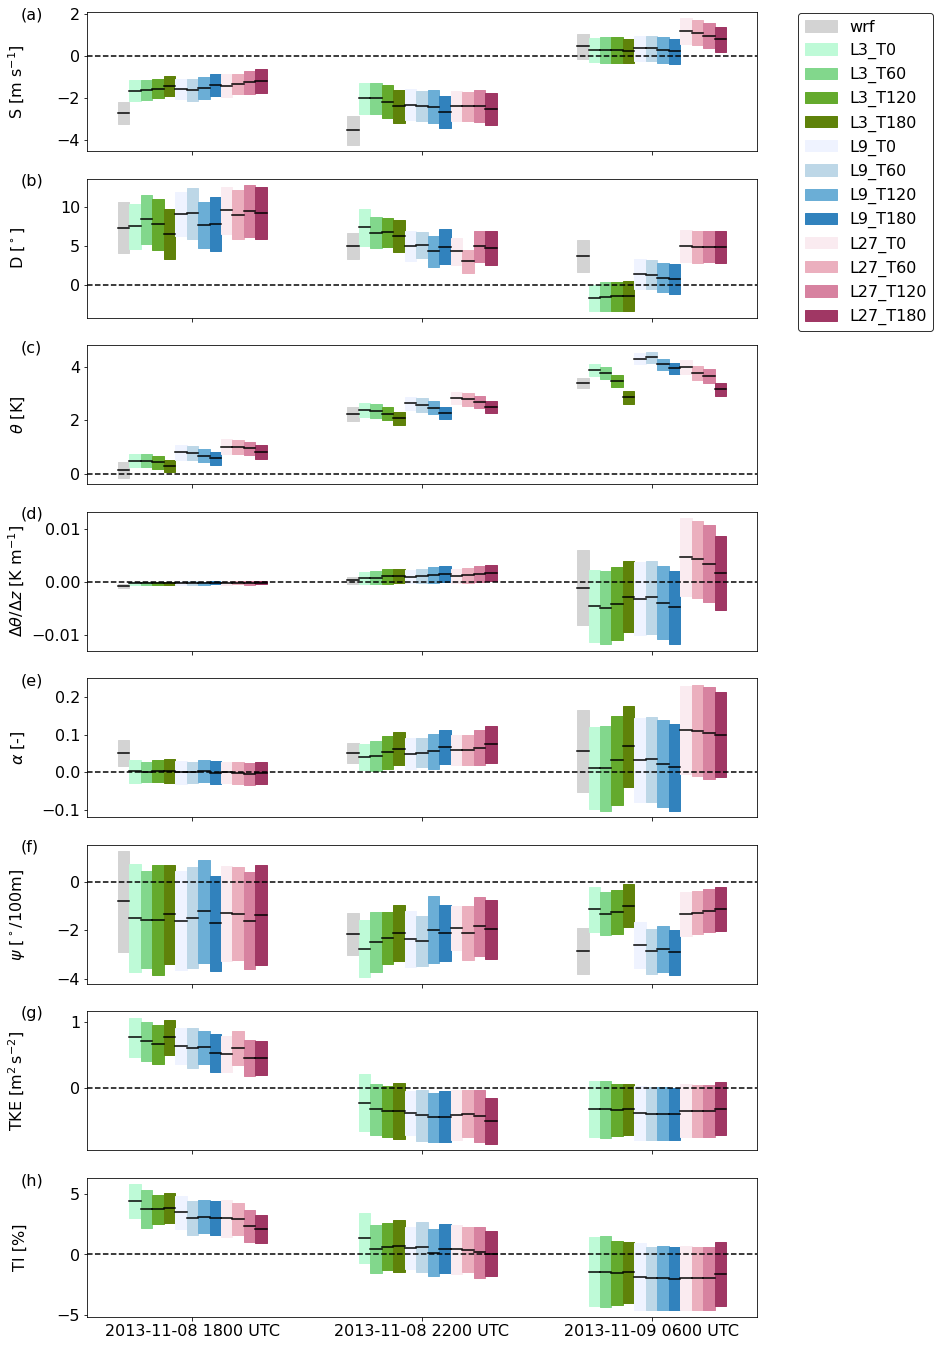

In [30]:
nrows = len(selected_fields)
fig, ax = plt.subplots(nrows,1,sharex=True,figsize=(12,3*nrows))
bar_width = 0.05

# Assign colorpaettes to group of simulations
color_palettes = {'L3':D1_swatch_B,'L9':D2_swatch_D,'L27':D3_swatch_I}

# Loop over fields and simulations
for i, field in enumerate(selected_fields):
    for j,dfname in enumerate(selected_sims):
        # Scale TI to be in percentage
        scale = 1
        if field == 'TI':
            scale = 100
        # Scale psi to be in degree per 100 meter
        elif field == 'psi':
            scale = 100
        
        # Set color of wrf to gray
        if dfname=='wrf':
            color = 'lightgray'
        else:
            L,T = dfname.replace('T','').split('_')
            color = color_palettes[L][-1::-1][int(float(T)/60)]
        
        # Loop over selected times
        for k, time in enumerate(selected_times):
            # Retrieve error metrics
            ME  = metrics.loc[(time,'ME',dfname),field].values
            STD = metrics.loc[(time,'STD',dfname),field].values
                
            # Compute x,y,width,height of bar based on ME and STD
            width = bar_width
            height = 2*STD
            x = k+(j-0.5)*width
            y = ME-STD
            
            # Scale y and height
            y *= scale
            height *= scale
                
            # Set label (only once)
            if k==0:
                label=dfname
            else:
                label=None
                    
            # Create rectangle and add to plot
            rect = mpl.patches.Rectangle((x,y),width,height,label=label,color=color)
            ax[i].add_patch(rect)
            # Plot horizontal line at ME
            ax[i].plot([x,x+width],[y+height/2,y+height/2],'-k',solid_capstyle='projecting')       

# Add zero line
for axi in ax:
    axi.axhline(color='k',linestyle='--')
    
for i,axi in enumerate(np.asarray(ax).ravel()):
    axi.text(-0.1,.95,'('+chr(i+97)+')',transform=axi.transAxes,size=16)

# Mark-up legend
leg = ax[0].legend(loc='upper left',bbox_to_anchor=(1.05,1.05),fontsize=16)
leg.get_frame().set_edgecolor('k')

# Mark-up x axis
ax[0].set_xticks(np.arange(len(selected_times)) + 6*bar_width)
ax[0].set_xticklabels(pd.to_datetime(selected_times).strftime('%Y-%m-%d %H%M UTC'),fontsize=16)

# Mark-up y axis
ax[0].set_ylabel('S [m s$^{-1}$]')
ax[1].set_ylabel(r'D [$^\circ$]')
ax[2].set_ylabel(r'$\theta$ [K]')
ax[3].set_ylabel(r'$\Delta\theta/\Delta z$ [K m$^{-1}$]')
ax[4].set_ylabel(r'$\alpha$ [-]')
ax[5].set_ylabel(r'$\psi$ [$^\circ$/100m]')
ax[6].set_ylabel(r'TKE [$\mathrm{m^2\,s^{-2}}$]')
ax[7].set_ylabel('TI [%]')
fig.align_ylabels()

#Save figure
figname = 'all_ME_STD'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')

### Figure 15

In [26]:
# Group simulations
L3 = {'T = 0 min': micro_prob_fspec['L3_T0'],
      'T = 60 min': micro_prob_fspec['L3_T60'],
      'T = 120 min': micro_prob_fspec['L3_T120'],
      'T = 180 min': micro_prob_fspec['L3_T180']}
L9 = {'T = 0 min': micro_prob_fspec['L9_T0'],
      'T = 60 min': micro_prob_fspec['L9_T60'],
      'T = 120 min': micro_prob_fspec['L9_T120'],
      'T = 180 min': micro_prob_fspec['L9_T180']}
L27 = {'T = 0 min': micro_prob_fspec['L27_T0'],
      'T = 60 min': micro_prob_fspec['L27_T60'],
      'T = 120 min': micro_prob_fspec['L27_T120'],
      'T = 180 min': micro_prob_fspec['L27_T180']}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


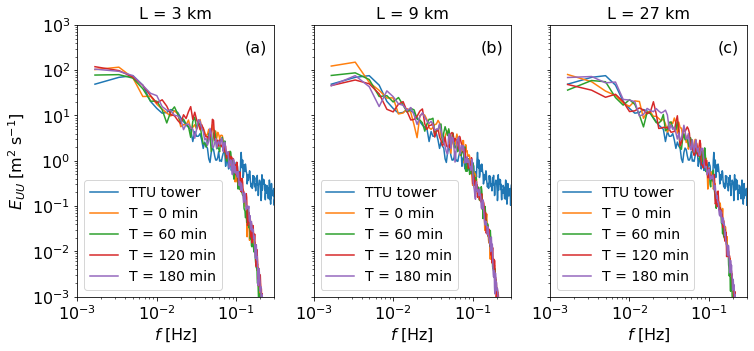

In [27]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
fig,_ = plot_spectrum(datasets = {'TTU tower': tower_fspec,**L3},
                      height = 80,
                      fields = ['wspd'],
                      times = ['2013-11-08 18:00:00'],
                      showlegend=True,
                      fig=fig,ax=ax[0],
                      )
fig,_ = plot_spectrum(datasets = {'TTU tower': tower_fspec,**L9},
                      height = 80,
                      fields = ['wspd'],
                      times = ['2013-11-08 18:00:00'],
                      showlegend=True,
                      fig=fig,ax=ax[1],
                      )
fig,_ = plot_spectrum(datasets = {'TTU tower': tower_fspec,**L27},
                      height = 80,
                      fields = ['wspd'],
                      times = ['2013-11-08 18:00:00'],
                      showlegend=True,
                      fig=fig,ax=ax[2],
                      )

fig.subplots_adjust(wspace=0.2)

# Remove obsolete labels and ticks on y axes
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

# Set title
ax[0].set_title('L = 3 km',fontsize=16)
ax[1].set_title('L = 9 km',fontsize=16)
ax[2].set_title('L = 27 km',fontsize=16)

# Add legends
ax[0].legend(loc='lower left',fontsize=14)
ax[1].legend(loc='lower left',fontsize=14)
ax[2].legend(loc='lower left',fontsize=14)

# Set x and y limits
for axi in ax:
    axi.set_ylim([10**(-3),1*10**3])
    axi.set_xlim([10**(-3),3*10**(-1)])
    
# Label subplots
for i,axi in enumerate(np.asarray(ax).ravel()):
    axi.text(.85,.9,'('+chr(i+97)+')',transform=axi.transAxes,size=16)

#Save figure
figname = 'all_spectra'
plt.savefig(os.path.join(figuredir,figname+'.png'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.eps'),bbox_inches='tight')
plt.savefig(os.path.join(figuredir,figname+'.pdf'),bbox_inches='tight')